# EDA Milestone

Name: Isha Kashyap

Research Question: To what extent can self-supervised learning be used as a method to accurately classify the detection of toxicity in videos capturing cloud formations from factories?

Date: 22-03-2024

Github link: https://github.com/ishakashyap/spotting-toxic-clouds-thesis

For my thesis, my task is to perform a self-supervised learning method on videos of factory emissions to classify whether or not there are toxic emissions visibly present in the videos.

This notebook contains code to visualize data and understand it better. Since I am performing a self-supervised learning task on this data, I do not have labels of my data and therefore cannot say anything about the distribution of the labels. Instead, I will show how the data augmentation works and what is being input into the models. Moreover, I can take labels from a different dataset from the same source and inspect those labels.

I currently have 20.000 unlabeled videos of factories provided by my supervisor. The data stems from the CMU Create Lab, whom collected videos from volunteers. These videos are all 3 second-long videos of factory emissions all with 180x180 resolution. Some do not have any emissions in them, some have hydrogen and toxic emissions in them and some only one of the two. 

Below you can find how one frame can be transformed to help make the features of the data more generalizable.

In [3]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In this example I take one video from my data and read one frame.

In [6]:
# Read the data from the filepath
cap = cv2.VideoCapture("train_full/0-0-2019-01-11-6304-884-6807-1387-180-180-8143-1547237420-1547237595.mp4")
success, frame = cap.read()
cap.release()
if success:
    # Convert BGR to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame_rgb)

For my transformations I resize the data, perform a Gaussian blur, Color jitter, Grayscale, Horizontal flip, Random rotation and Center crop. I finally transform my frame to a tensor and normalize it to make the eventual training process more stable, but this can be ignored for now.

In [18]:
# Add the transformation tasks
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [19]:
transformed_frame = transform(frame)

Now we plot the before and after of the frame. Every time this transformation is run, the results will be different due to the randomness of some of the transformations.

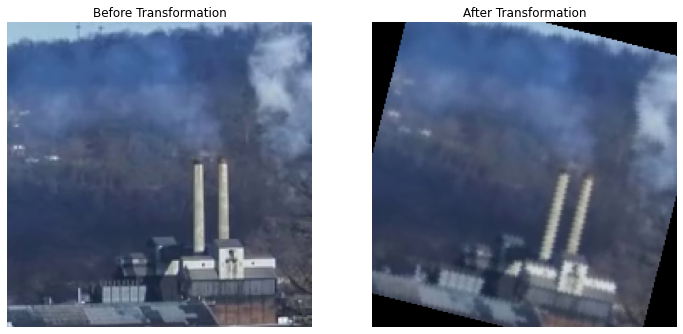

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(frame)
ax[0].set_title("Before Transformation")
ax[1].imshow(transformed_frame.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize
ax[1].set_title("After Transformation")
for a in ax:
    a.axis('off')
plt.show()

# Distribution of labels

Although the data I will be using does not have labels, I do have access to data from the same source that does have labels. Below, I will visualize the distribution of these labels to get an idea of how the unlabeled data might look. For this, I will use a .json file that matches the video files with their respective labels (also provided by CMU Create Lab).

In [23]:
import json
from collections import Counter
import matplotlib.pyplot as plt

with open('metadata_02242020.json', 'r') as file:
    json_data = json.load(file)

label_state_admin_values = [item["label_state_admin"] for item in json_data]

distribution = Counter(label_state_admin_values)

print(len(json_data))
print(distribution)

12567
Counter({16: 5642, 23: 4365, -1: 2560})


In total, there are 12567 videos in this particular dataset with labels. There are three label ids that appear in this .json file.

Label id 16 describes a strong negative for toxic clouds in the video, label id 23 a strong positive and label id -1 means its label is not yet verified by the researchers who have made it public.

Below, I exclude label id -1 and plot the distribution in a bar chart.

10007


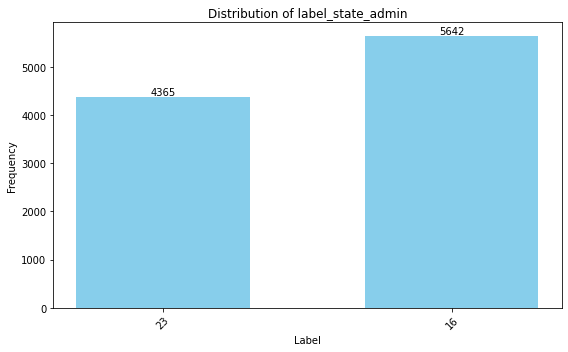

In [31]:
filtered_distribution = {key: val for key, val in distribution.items() if key != -1}
labels = [str(label) for label in filtered_distribution.keys()]
counts = list(filtered_distribution.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue', width=0.6)

plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of label_state_admin')
plt.xticks(rotation=45)

for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

As seen above, the data is fairly evenly distributed across positive and negative labels. 

Now let's calculate the percentages.

In [33]:
total_count = sum(filtered_distribution.values())
print(total_count)

label_percentages = {label: (count / total_count) * 100 for label, count in filtered_distribution.items()}

print(label_percentages)

10007
{23: 43.61946637353852, 16: 56.380533626461485}


Filtering out the -1 label id eliminates 2560 videos. Now the distribution is 4365 positive instances for toxic clouds and 5642 negative instances for toxic clouds, which is a 44/56 ratio.

From this information, I can assume not much of a data imbalance can appear. 